In [0]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split
from PIL import Image
import requests
import os

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, utils, datasets, preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet, vgg16, inception_v3

tf.random.set_seed(17)

TensorFlow 2.x selected.


In [0]:
!rm -rf cousteau
!git clone https://github.com/datawookie/cousteau.git
  
from cousteau.keras.plot import plot_history

Cloning into 'cousteau'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 6), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [0]:
!rm -rf car-dataset # allows us to re-clone the dataset w/ updates and get the changes - if folder exists, clone does not work and we won't get anychanges
!git clone https://github.com/GerardWalsh/car-dataset.git

Cloning into 'car-dataset'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 240 (delta 39), reused 229 (delta 30), pack-reused 0
Receiving objects: 100% (240/240), 10.14 MiB | 28.21 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [0]:
image_paths = list(paths.list_images("car-dataset/train"))

images = []
labels = []

for path in image_paths:
  img = preprocessing.image.load_img(path, target_size=(224, 224))
  img = np.expand_dims(img, axis=0)
  
  images.append(img)

  label = path.split(os.path.sep)[-2]
  labels.append(1 if label == "7" else 0)

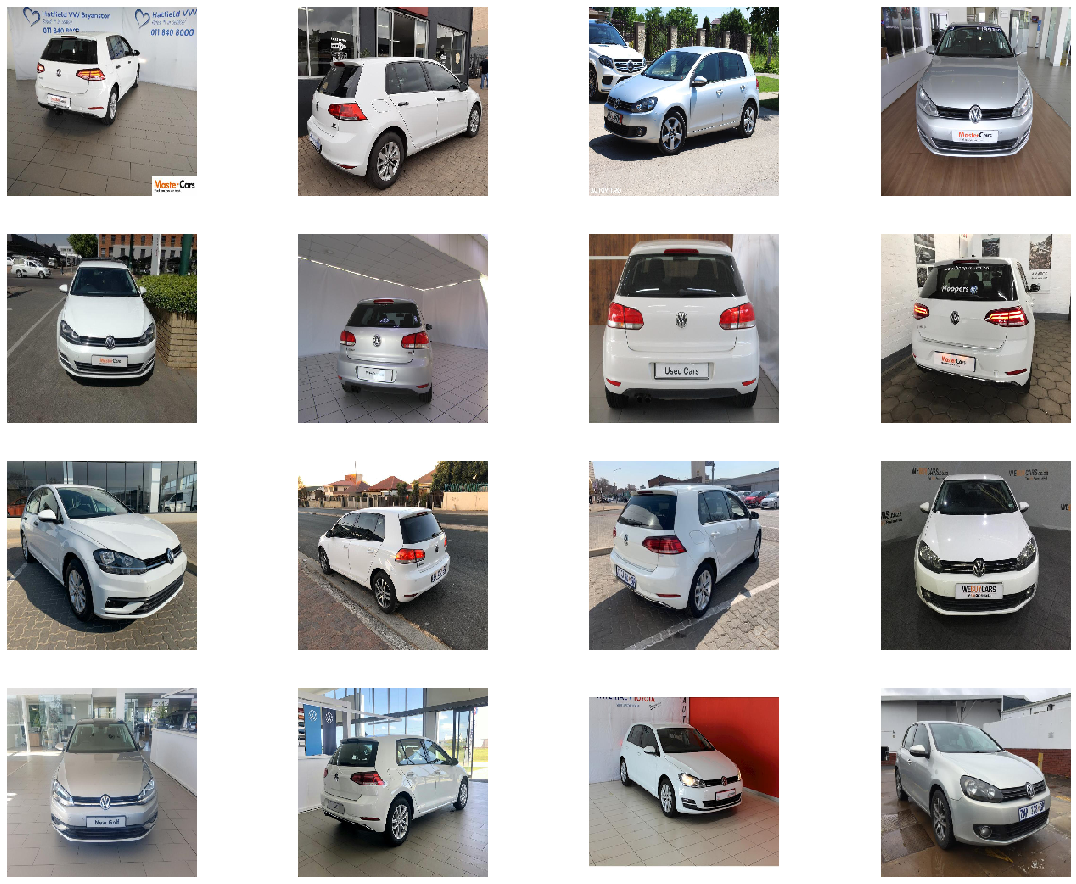

In [0]:
fig = plt.figure(figsize = (20, 16))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))

plt.show()

In [0]:
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
def augment_image(image, replicates=4):
    images = [image]
    i = 1
    for batch in datagen.flow(image, batch_size=1):
        images.append(batch)
        i += 1
        if i >= replicates:
            break
    return images

In [0]:
REPLICATES = 4

In [0]:
images = [augment_image(image, REPLICATES) for image in images]

In [0]:
images = [image for sublist in images for image in sublist]

In [0]:
len(images)

564

In [0]:
fig = plt.figure(figsize = (12, 12))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  # Transformations result in float32, so cast to uint8.
  plt.imshow(np.squeeze(img).astype('uint8'))

plt.show()

TypeError: ignored

<Figure size 864x864 with 0 Axes>

In [0]:
labels = [[label] * REPLICATES for label in labels]
labels = [label for sublist in labels for label in sublist]

In [0]:
labels = np.array(labels)

In [0]:
images = np.concatenate(images)

In [0]:
input_shape = images.shape[1:]

In [0]:
images = resnet.preprocess_input(images)

In [0]:
(X_train, X_test, y_train, y_test) = train_test_split(images, labels, test_size=0.2, random_state=13)

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(20, kernel_size=5, activation = 'relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=2))

model.add(layers.Conv2D(50, kernel_size=5, activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size=2))      

model.add(layers.Flatten())
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(2, activation = 'softmax'))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 20)      1520      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 50)      25050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 140450)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                4494432   
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                1

In [0]:
batch_size = 32
epochs = 10

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

In [0]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split=0.2
)

Train on 360 samples, validate on 91 samples
Epoch 1/10
360/360 [==============================] - 4s 10ms/sample - loss: 1.2258 - accuracy: 0.5444 - val_loss: 2.3298 - val_accuracy: 0.5604
Epoch 2/10
360/360 [==============================] - 1s 2ms/sample - loss: 0.8645 - accuracy: 0.6750 - val_loss: 1.8980 - val_accuracy: 0.5604
Epoch 3/10
360/360 [==============================] - 1s 2ms/sample - loss: 0.6285 - accuracy: 0.7167 - val_loss: 1.5832 - val_accuracy: 0.5495
Epoch 4/10
360/360 [==============================] - 1s 2ms/sample - loss: 0.5691 - accuracy: 0.7361 - val_loss: 1.7968 - val_accuracy: 0.5604
Epoch 5/10
360/360 [==============================] - 1s 2ms/sample - loss: 0.5434 - accuracy: 0.7639 - val_loss: 1.3400 - val_accuracy: 0.5934
Epoch 6/10
360/360 [==============================] - 1s 2ms/sample - loss: 0.4400 - accuracy: 0.8083 - val_loss: 0.9451 - val_accuracy: 0.6154
Epoch 7/10
360/360 [==============================] - 1s 2ms/sample - loss: 0.3881 - accur

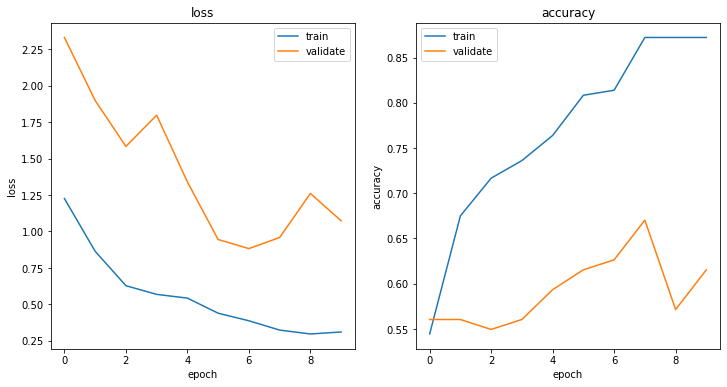

In [0]:
plot_history(history)

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 65.49% 
Test loss     = 0.970258


# Transfer learning

In [0]:
base_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

In [0]:
base_model.summary()

In [0]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1605648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 25,193,458
Trainable params: 25,140,306
Non-trainable params: 53,152
_____________________________________

In [0]:
base_model.trainable = False

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1605648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 25,193,458
Trainable params: 1,605,714
Non-trainable params: 23,587,744
__________________________________

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [0]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_split=0.2
)

Train on 360 samples, validate on 91 samples
Epoch 1/20
360/360 [==============================] - 8s 21ms/sample - loss: 1.0263 - accuracy: 0.5194 - val_loss: 0.8148 - val_accuracy: 0.5385
Epoch 2/20
360/360 [==============================] - 2s 6ms/sample - loss: 0.8174 - accuracy: 0.6000 - val_loss: 0.7225 - val_accuracy: 0.5714
Epoch 3/20
360/360 [==============================] - 2s 6ms/sample - loss: 0.7303 - accuracy: 0.6444 - val_loss: 0.6438 - val_accuracy: 0.6374
Epoch 4/20
360/360 [==============================] - 2s 6ms/sample - loss: 0.5520 - accuracy: 0.7389 - val_loss: 0.6061 - val_accuracy: 0.6923
Epoch 5/20
360/360 [==============================] - 2s 6ms/sample - loss: 0.4731 - accuracy: 0.7889 - val_loss: 0.5823 - val_accuracy: 0.7033
Epoch 6/20
360/360 [==============================] - 2s 6ms/sample - loss: 0.4170 - accuracy: 0.7944 - val_loss: 0.5589 - val_accuracy: 0.7033
Epoch 7/20
360/360 [==============================] - 2s 6ms/sample - loss: 0.3433 - accur

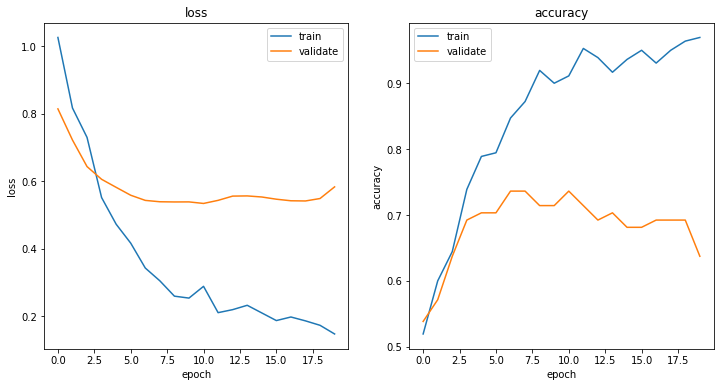

In [0]:
plot_history(history)

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 67.26% 
Test loss     = 0.606664


# Fine tune ResNet50

In [0]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

In [0]:
# base_model.summary()

In [0]:
def trainable_weights(model):
  return sum([int(tf.size(weights)) for weights in model.trainable_weights])

# How many trainable weights in the base model?
trainable_weights(base_model)

0

In [0]:
# Make the whole base model trainable (using model property).
base_model.trainable = True
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

23534592

In [0]:
# Set all layers not trainable (using layer properties).
for layer in base_model.layers:
   layer.trainable = False
# Set top two convolutional layers trainable.
for layer in base_model.layers[171:174]:
   layer.trainable = True
    
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

1054720

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1605648   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 25,193,458
Trainable params: 2,660,434
Non-trainable params: 22,533,024
__________________________________

In [0]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=5,
    verbose=1,
    validation_split=0.2
)

Train on 360 samples, validate on 91 samples
Epoch 1/5
360/360 [==============================] - 6s 18ms/sample - loss: 0.1538 - accuracy: 0.9611 - val_loss: 0.5731 - val_accuracy: 0.6703
Epoch 2/5
360/360 [==============================] - 2s 6ms/sample - loss: 0.1429 - accuracy: 0.9639 - val_loss: 0.5856 - val_accuracy: 0.6813
Epoch 3/5
360/360 [==============================] - 2s 6ms/sample - loss: 0.1241 - accuracy: 0.9722 - val_loss: 0.5247 - val_accuracy: 0.7143
Epoch 4/5
360/360 [==============================] - 2s 6ms/sample - loss: 0.1231 - accuracy: 0.9806 - val_loss: 0.5028 - val_accuracy: 0.7363
Epoch 5/5
360/360 [==============================] - 2s 6ms/sample - loss: 0.1310 - accuracy: 0.9778 - val_loss: 0.4864 - val_accuracy: 0.7363


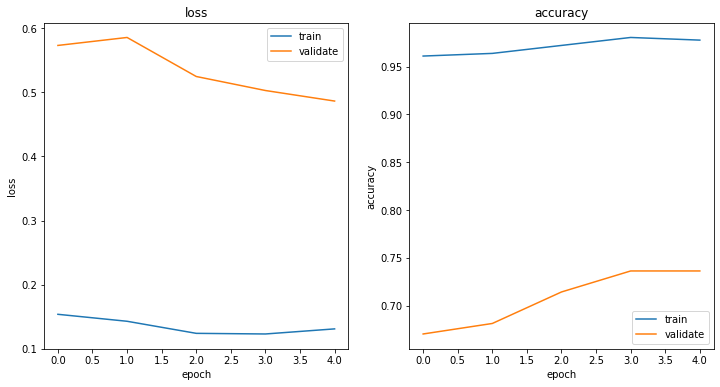

In [0]:
plot_history(history)

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 69.91% 
Test loss     = 0.551200


# Transfer learning with less complex architechture - VGG16

In [0]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                401424    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 15,116,210
Trainable params: 15,116,178
Non-trainable params: 32
_________________________________________

In [0]:
base_model.trainable = False

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                401424    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 15,116,210
Trainable params: 401,490
Non-trainable params: 14,714,720
____________________________________

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [0]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_split=0.2
)

Train on 360 samples, validate on 91 samples
Epoch 1/50
360/360 [==============================] - 8s 22ms/sample - loss: 1.2880 - accuracy: 0.4917 - val_loss: 2.6983 - val_accuracy: 0.5275
Epoch 2/50
360/360 [==============================] - 3s 7ms/sample - loss: 1.1758 - accuracy: 0.5167 - val_loss: 1.9996 - val_accuracy: 0.5165
Epoch 3/50
360/360 [==============================] - 3s 7ms/sample - loss: 1.0798 - accuracy: 0.5667 - val_loss: 1.6811 - val_accuracy: 0.5275
Epoch 4/50
360/360 [==============================] - 3s 7ms/sample - loss: 1.0677 - accuracy: 0.5917 - val_loss: 1.5015 - val_accuracy: 0.5275
Epoch 5/50
360/360 [==============================] - 3s 7ms/sample - loss: 1.0026 - accuracy: 0.6000 - val_loss: 1.3715 - val_accuracy: 0.5385
Epoch 6/50
360/360 [==============================] - 3s 7ms/sample - loss: 1.0143 - accuracy: 0.5889 - val_loss: 1.2643 - val_accuracy: 0.5385
Epoch 7/50
360/360 [==============================] - 3s 7ms/sample - loss: 0.8693 - accur

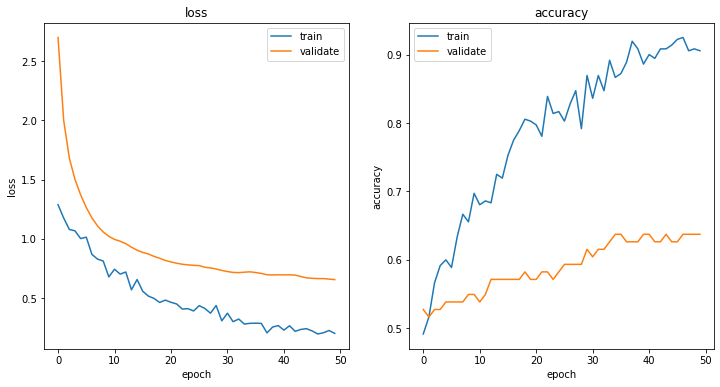

In [0]:
plot_history(history)

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 70.80% 
Test loss     = 0.643782


# Fine tune VGG16

In [0]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [0]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
base_model.trainable = True
# How many trainable weights in the base model?
trainable_weights(base_model)

14714688

In [0]:
# Make the whole base model trainable (using model property).
base_model.trainable = True
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

14714688

In [0]:
# Set all layers not trainable (using layer properties).
for layer in base_model.layers:
   layer.trainable = False
# Set top two convolutional layers trainable.
for layer in base_model.layers[15:18]:
   layer.trainable = True
    
# How many trainable weights in the base model?
trainable_weights(base_model)
# Check that this agrees with the model summary.

7079424

In [0]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                401424    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 15,116,210
Trainable params: 7,480,914
Non-trainable params: 7,635,296
___________________________________

In [0]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=1,
    verbose=1,
    validation_split=0.2
)

Train on 360 samples, validate on 91 samples
360/360 [==============================] - 4s 12ms/sample - loss: 0.1873 - accuracy: 0.9167 - val_loss: 0.6214 - val_accuracy: 0.6593


In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 72.57% 
Test loss     = 0.621164


In [0]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=5,
    verbose=1,
    validation_split=0.2
)

Train on 360 samples, validate on 91 samples
Epoch 1/5
360/360 [==============================] - 3s 8ms/sample - loss: 0.1933 - accuracy: 0.9250 - val_loss: 0.5989 - val_accuracy: 0.6813
Epoch 2/5
360/360 [==============================] - 3s 8ms/sample - loss: 0.1719 - accuracy: 0.9250 - val_loss: 0.5762 - val_accuracy: 0.6923
Epoch 3/5
360/360 [==============================] - 3s 8ms/sample - loss: 0.1624 - accuracy: 0.9333 - val_loss: 0.5635 - val_accuracy: 0.7033
Epoch 4/5
360/360 [==============================] - 3s 8ms/sample - loss: 0.1592 - accuracy: 0.9472 - val_loss: 0.5590 - val_accuracy: 0.6923
Epoch 5/5
360/360 [==============================] - 3s 8ms/sample - loss: 0.1324 - accuracy: 0.9500 - val_loss: 0.5865 - val_accuracy: 0.7363


In [0]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 76.11% 
Test loss     = 0.533765


# Unseen data

In [0]:
def classify(img_url, class_type):
  response = requests.get(img_url)
  if response.status_code == 200:
    if(class_type == '6'):
      os.chdir('car-dataset/train/6')
      filename = str(max(sorted([int(prefix.split('.')[0]) for prefix in os.listdir()])) + 1)
    else:
      os.chdir('car-dataset/train/7')
      filename = str(max(sorted([int(prefix.split('.')[0]) for prefix in os.listdir()])) + 1)
    with open('{}.jpg'.format(filename), 'wb') as f:
        f.write(response.content)
        
  img = image.load_img('{}.jpg'.format(filename), target_size=(224, 224))
  os.chdir('../../..')
  plt.imshow(np.squeeze(img).astype('uint8'))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  print(('7' if (model.predict_classes(img) == 1) else '6'),  model.predict_proba(img))

## Golf 6

7 [[0.01022734 0.9897726 ]]


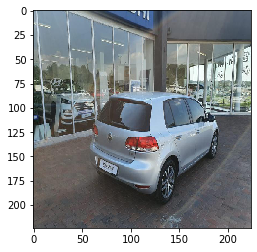

In [0]:
classify(
    'https://img.autotrader.co.za/4759009/Crop800x600',
    '6'
)

6 [[0.97404194 0.02595809]]


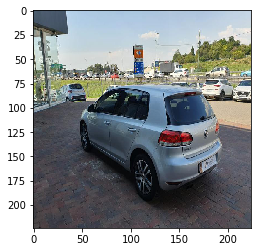

In [0]:
classify(
    'https://img.autotrader.co.za/4759008/Crop800x600',
    '6'
)

6 [[0.8925083  0.10749168]]


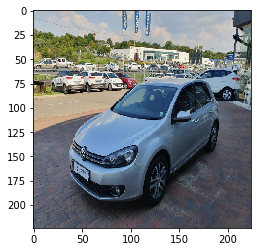

In [0]:
classify(
    'https://img.autotrader.co.za/4759007/Crop800x600',
    '6'
)

## Golf 7


7 [[0.24639584 0.7536041 ]]


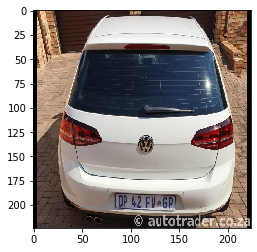

In [0]:
classify(
    'https://img.autotrader.co.za/4790868/Crop800x600',
    '7'
)